In [63]:
import numpy as np
import pandas as pd

random_state = 31 #Why 31? It's my birthday xd

def load_data(train_file, test_size=0.2, random_state=None):
    # Load the MNIST dataset
    train_data = pd.read_csv(train_file)
    
    X = train_data.drop('label', axis=1).values
    y = train_data['label'].values
    
    # Normalize the input features
    X = X / 255.0
    
    if random_state is not None:
        np.random.seed(random_state)
    
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    test_samples = int(num_samples * test_size)
    train_indices = indices[test_samples:]
    test_indices = indices[:test_samples]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    return X_train, y_train, X_test, y_test

# Convert labels to one-hot encoded vectors
def one_hot_encode(labels, num_classes):
    num_samples = labels.shape[0]
    one_hot = np.zeros((num_samples, num_classes))
    one_hot[np.arange(num_samples), labels] = 1
    return one_hot

# Initialize weights and biases using Xavier initialization
def initialize_parameters(input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
    np.random.seed(42)
    
    W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2 / (input_size + hidden_size1))
    b1 = np.zeros(hidden_size1)

    W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2 / (hidden_size1 + hidden_size2))
    b2 = np.zeros(hidden_size2)

    W3 = np.random.randn(hidden_size2, hidden_size3) * np.sqrt(2 / (hidden_size2 + hidden_size3))
    b3 = np.zeros(hidden_size3)

    W4 = np.random.randn(hidden_size3, output_size) * np.sqrt(2 / (hidden_size3 + output_size))
    b4 = np.zeros(output_size)
    
    parameters = {
        'W1': W1, 'b1': b1,
        'W2': W2, 'b2': b2,
        'W3': W3, 'b3': b3,
        'W4': W4, 'b4': b4
    }
    
    return parameters

# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Define the softmax activation function
def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Forward propagation
def forward_propagation(X, parameters):
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
    W3, b3 = parameters['W3'], parameters['b3']
    W4, b4 = parameters['W4'], parameters['b4']
    
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    
    z3 = np.dot(a2, W3) + b3
    a3 = relu(z3)
    
    z4 = np.dot(a3, W4) + b4
    a4 = softmax(z4)
    
    cache = {
        'a1': a1, 'z1': z1,
        'a2': a2, 'z2': z2,
        'a3': a3, 'z3': z3,
        'a4': a4, 'z4': z4
    }
    
    return a4, cache

# Backpropagation
def backward_propagation(X, y, cache, parameters):
    m = X.shape[0]
    
    a1, z1 = cache['a1'], cache['z1']
    a2, z2 = cache['a2'], cache['z2']
    a3, z3 = cache['a3'], cache['z3']
    a4, z4 = cache['a4'], cache['z4']
    
    delta4 = a4 - y
    delta3 = np.dot(delta4, parameters['W4'].T) * (z3 > 0).astype(float)
    delta2 = np.dot(delta3, parameters['W3'].T) * (z2 > 0).astype(float)
    delta1 = np.dot(delta2, parameters['W2'].T) * (z1 > 0).astype(float)
    
    dW4 = np.dot(a3.T, delta4) / m
    db4 = np.sum(delta4, axis=0) / m
    
    dW3 = np.dot(a2.T, delta3) / m
    db3 = np.sum(delta3, axis=0) / m
    
    dW2 = np.dot(a1.T, delta2) / m
    db2 = np.sum(delta2, axis=0) / m
    
    dW1 = np.dot(X.T, delta1) / m
    db1 = np.sum(delta1, axis=0) / m
    
    gradients = {
        'dW4': dW4, 'db4': db4,
        'dW3': dW3, 'db3': db3,
        'dW2': dW2, 'db2': db2,
        'dW1': dW1, 'db1': db1
    }
    
    return gradients

# Update parameters
def update_parameters(parameters, gradients, learning_rate):
    parameters['W4'] -= learning_rate * gradients['dW4']
    parameters['b4'] -= learning_rate * gradients['db4']
    
    parameters['W3'] -= learning_rate * gradients['dW3']
    parameters['b3'] -= learning_rate * gradients['db3']
    
    parameters['W2'] -= learning_rate * gradients['dW2']
    parameters['b2'] -= learning_rate * gradients['db2']
    
    parameters['W1'] -= learning_rate * gradients['dW1']
    parameters['b1'] -= learning_rate * gradients['db1']
    
    return parameters

# Calculate accuracy
def calculate_accuracy(X, y, parameters):
    a4, _ = forward_propagation(X, parameters)
    predicted_labels = np.argmax(a4, axis=1)
    accuracy = np.mean(predicted_labels == y) * 100
    return accuracy

# Train the model
def train_model(X_train, y_train, X_val, y_val, input_size, hidden_size1, hidden_size2, hidden_size3, output_size,
                learning_rate, num_epochs):
    num_samples = X_train.shape[0]
    num_classes = output_size
    
    y_train_encoded = one_hot_encode(y_train, num_classes)
    
    parameters = initialize_parameters(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
    
    for epoch in range(num_epochs):
        a4, cache = forward_propagation(X_train, parameters)
        
        gradients = backward_propagation(X_train, y_train_encoded, cache, parameters)
        
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        if (epoch + 1) % 100 == 0:
            train_accuracy = calculate_accuracy(X_train, y_train, parameters)
            val_accuracy = calculate_accuracy(X_val, y_val, parameters)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")
    
    return parameters

# Test the model
def predict(X_test, parameters):
    a4, _ = forward_propagation(X_test, parameters)
    predicted_labels = np.argmax(a4, axis=1)
    return predicted_labels


# Path to train.csv
train_file = 'train.csv'

# Load the MNIST dataset and split into train, validation, and test sets
X_train, y_train, X_val, y_val = load_data(train_file)

input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 10

learning_rate = 0.1
num_epochs = 1000

# Train the model
parameters = train_model(X_train, y_train, X_val, y_val, input_size, hidden_size1, hidden_size2, hidden_size3, output_size,
                         learning_rate, num_epochs)

# Make predictions on the test set
predicted_labels = predict(X_test, parameters)

# Print the predicted labels
print("Predicted labels:", predicted_labels)


Epoch 100/1000, Train Accuracy: 82.44%, Val Accuracy: 82.04%
Epoch 200/1000, Train Accuracy: 89.28%, Val Accuracy: 89.58%
Epoch 300/1000, Train Accuracy: 92.03%, Val Accuracy: 91.67%
Epoch 400/1000, Train Accuracy: 93.09%, Val Accuracy: 92.60%
Epoch 500/1000, Train Accuracy: 93.91%, Val Accuracy: 93.44%
Epoch 600/1000, Train Accuracy: 94.64%, Val Accuracy: 93.88%
Epoch 700/1000, Train Accuracy: 95.12%, Val Accuracy: 94.31%
Epoch 800/1000, Train Accuracy: 95.59%, Val Accuracy: 94.60%
Epoch 900/1000, Train Accuracy: 95.94%, Val Accuracy: 94.90%
Epoch 1000/1000, Train Accuracy: 96.30%, Val Accuracy: 95.05%
Predicted labels: [5 7 5 ... 7 6 9]


In [64]:
import matplotlib.pyplot as plt

def display_samples(X, y_true, y_pred, num_samples=5):
    sample_indices = np.random.choice(len(X), size=num_samples, replace=False)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 4))
    fig.tight_layout()
    
    for i, idx in enumerate(sample_indices):
        image = X[idx].reshape(28, 28)
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    
    plt.show()


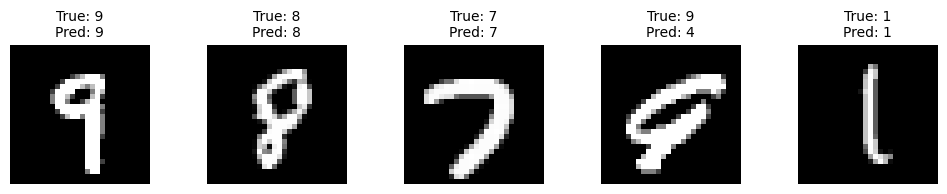

In [65]:
# Make predictions on the test set
predicted_labels = predict(X_test, parameters)

# Display a few samples with their predicted and true values
display_samples(X_test, y_test, predicted_labels, num_samples=5)
